In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Chap 9. 차원분석
## 9.1 주성분분석 principal component analysis
- 서로 상관관계를 갖는 많은 변수를 상관관계가 없는 소수의 변수로 변환하는 차원축소 기법
- 선형결합을 위한 가중치는 주성분 간 상관관계가 없으면서 각 주성분이 설명하는 분산이 최대회되도록 결정
- 변수들이 가지고 있는 총 표본분산을 많이 설명해주는 순서대로 순차적으로 추출
- 변수 갯수 선택
  - 전체 분산의 80%
$$ PC_i = \sum^n_i component\ loading_i \times x_i$$

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

state = pd.read_csv("../data/kwak/state.x77.csv", index_col=0)

scaler = StandardScaler()
state_scaled = pd.DataFrame(scaler.fit_transform(state), columns=state.columns, index=state.index)

pca = PCA(n_components=len(state_scaled.columns), random_state=1).fit(state_scaled)
state_pca = pd.DataFrame(pca.transform(state_scaled), columns=map(lambda x:'PC' + str(x), range(len(state.columns))), index=state.index)

print('데이터 총 분산', np.sum(np.diag(pca.get_covariance())))
print('주성분의 분산', pca.explained_variance_.round(3))
print('분산 설명 비율', pca.explained_variance_ratio_.round(3))
print('누적 분산 비율', np.cumsum(pca.explained_variance_ratio_).round(3))

데이터 총 분산 8.163265306122454
주성분의 분산 [3.672 1.665 1.135 0.722 0.392 0.314 0.147 0.115]
분산 설명 비율 [0.45  0.204 0.139 0.088 0.048 0.038 0.018 0.014]
누적 분산 비율 [0.45  0.654 0.793 0.881 0.929 0.968 0.986 1.   ]


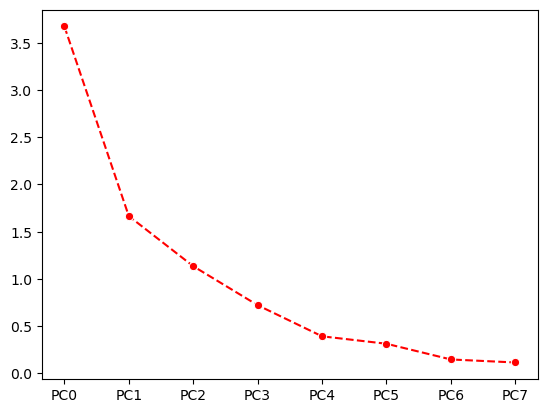

In [101]:
sns.lineplot(x=state_pca.columns, y = pca.explained_variance_, color='r', linestyle='--', marker='o');

In [102]:
# 성분적재값 component loadings : 각 피쳐와 상관계수
comp_loading = pd.DataFrame(pca.components_.T, columns=state_pca.columns, index=state_scaled.columns).round(3)
comp_loading

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Population,0.126,0.411,-0.656,-0.409,0.406,-0.011,0.062,0.219
Income,-0.299,0.519,-0.100,-0.088,-0.638,0.462,-0.009,-0.060
Illiteracy,0.468,0.053,0.071,0.353,0.004,0.387,0.620,0.339
Life Exp,-0.412,-0.082,-0.360,0.443,0.327,0.219,0.256,-0.527
Murder,0.444,0.307,0.108,-0.166,-0.128,-0.325,0.295,-0.678
HS Grad,-0.425,0.299,0.050,0.232,-0.099,-0.645,0.393,0.307
Frost,-0.357,-0.154,0.387,-0.619,0.217,0.213,0.472,-0.028
Area,-0.033,0.588,0.510,0.201,0.499,0.148,-0.286,-0.013


In [103]:
# 성분 점수 : PCA 원본 값 = scaled data * component loading
comp_score = pd.DataFrame(state_scaled.values @ comp_loading.values, index=state_scaled.index, columns=state_pca.columns)
comp_score.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
rownames,,,,,,,,
Alabama,3.828854,-0.236331,0.230229,0.385302,-0.249106,-0.438793,-0.057452,-0.540543
Alaska,-1.061510,5.514218,4.282230,0.581374,0.111788,1.010131,-0.302983,0.121834
Arizona,0.876098,0.753753,0.078214,1.737020,-0.564075,-0.309225,-0.131564,0.529636
Arkansas,2.406854,-1.301539,0.223750,0.628002,0.655033,0.261201,-0.034131,-0.492480
California,0.240851,3.546822,-2.833568,-0.068229,0.979809,-0.660112,-0.046200,0.259165


In [104]:
state_pca.corr()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
PC0,1.000000e+00,-5.638273e-16,8.879831e-18,3.061356e-17,5.850448e-16,1.730908e-16,5.497141e-16,7.479877e-17
PC1,-5.638273e-16,1.000000e+00,-5.022323e-16,3.860400e-16,-5.561868e-16,-2.333389e-16,-7.581749e-17,1.266343e-15
PC2,8.879831e-18,-5.022323e-16,1.000000e+00,3.029146e-16,-3.768722e-16,-2.278532e-17,9.972749e-17,5.977273e-16
PC3,3.061356e-17,3.860400e-16,3.029146e-16,1.000000e+00,-1.191806e-16,5.712964e-17,2.691476e-16,8.042665e-17
PC4,5.850448e-16,-5.561868e-16,-3.768722e-16,-1.191806e-16,1.000000e+00,-9.846602e-17,3.603185e-16,-5.852954e-16
PC5,1.730908e-16,-2.333389e-16,-2.278532e-17,5.712964e-17,-9.846602e-17,1.000000e+00,8.534397e-16,5.162792e-16
PC6,5.497141e-16,-7.581749e-17,9.972749e-17,2.691476e-16,3.603185e-16,8.534397e-16,1.000000e+00,4.287072e-17
PC7,7.479877e-17,1.266343e-15,5.977273e-16,8.042665e-17,-5.852954e-16,5.162792e-16,4.287072e-17,1.000000e+00


Visualization learned from https://www.jcchouinard.com/python-pca-biplots-machine-learning/

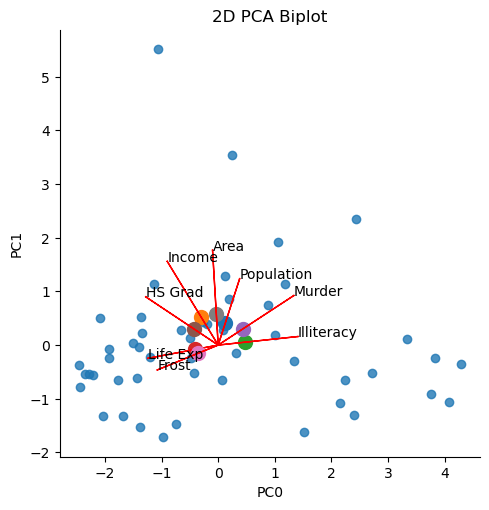

In [134]:
# 2D Biplot visualization
xs = comp_loading['PC0']
ys = comp_loading['PC1']

sns.lmplot(x='PC0', y='PC1', data=state_pca, fit_reg=False);

for i, varnames in enumerate(state_scaled.columns):
    plt.scatter(xs[i], ys[i], s=100)
    plt.arrow(0, 0, xs[i]*3, ys[i]*3, color='r', head_width=0.01)
    plt.text(xs[i]*3, ys[i]*3, varnames)

plt.xlabel("PC0")
plt.ylabel("PC1")
plt.title("2D PCA Biplot");

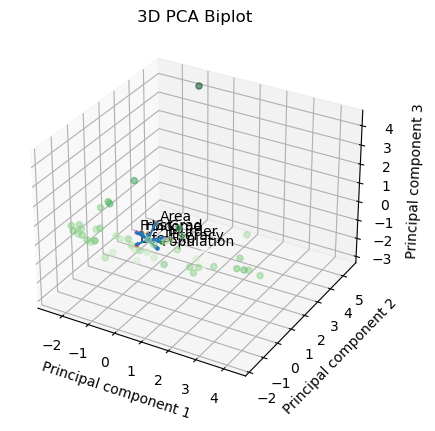

In [133]:
# 3D Biplot visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter3D(state_pca['PC0'], state_pca['PC1'], state_pca['PC2'], c=state_pca['PC2'], cmap='Greens', alpha=0.5)

xs = comp_loading['PC0']
ys = comp_loading['PC1']
zs = comp_loading['PC2']

for i, varnames in enumerate(state_scaled.columns):
    ax.scatter(xs[i], ys[i], zs[i], s=5)
    ax.text(xs[i]+0.1, ys[i]+0.1, zs[i]+0.1, varnames)

x_arr = np.zeros(len(comp_loading['PC0']))
y_arr = z_arr = x_arr
ax.quiver(x_arr, y_arr, z_arr, xs, ys, zs)

plt.title(f'3D PCA Biplot')
  
ax.set_xlabel('Principal component 1', rotation=150)
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3', rotation=60)
  
plt.show()

## 9.2 요인분석
- 관측 가능한 여러 변수로부터 소슈의 요인(factor)를 추출하여 변수를 설명
- 여러 관측변수로부터 직접적으로 관측 가능하지 않은 공통의 요인추출 => 잠재되어 있는 해석가능한 소수의 요인 찾기가 목적
$$ x_i = b_{i1}F_1 + \dots + b_{ik}F_k+U_i \quad U:공통요인,\ b:요인적재값$$
$$ F_j = w_{j1}x_1+\dots+w_{jp}x_p\ \quad w_{jp}:요인점수계수$$

https://www.datacamp.com/tutorial/introduction-factor-analysis
- 요인분석 가정
  1) 이상치 없음
  2) 샘플 사이즈가 factor 사이즈보다 큼
  3) 다중공선성이 완벽하지 않음
  4) 등분산성이 완벽하지 않음

- 요인분석 가정 검증 : 샘플이 요인분석하기 적당한가?
  1) Bartlett's Test of sphericity : identity matrix와 상관관계 확인하여 변수간 상관성 확인. 검정이 유의하지 않을 시 요인분석 X
  2) Kaiser-Meyer-Olkin(KMO) : 모든 관측 변수의 분산비율 계산. 낮은 비율일 수록 요인분석에 적합하며, KMO 값이 0.6보다 작으면 부적합
 
- 요인갯수 선택 : eigenvalue가 1보다 높은 것 (Kaiser criterion) & scree plot 굴절지점 => 최종 결정은 실제로 분석 후 선택 필요

- 공통성(communality) : 공통요인에 의해 설명되는 분산의 비율 => 추출된 요인이 각 변수를 잘 설명하는지 평가, 높으면 설명 잘함
  - 공통요인에 의해 설명되지 않는 분산은 고유요인에 의해 설명되는 것으로 가정 (loading : 고유요인으로 설명되는 부분)
    $$ 1 - \sum loadings^2$$

- 타당도 평가
  - 타당도(validity) : 측정척도가 측정하기로 되어있는 개념을 그 척도가 적절히 측정하고 있는 정도
    - 집중 타당도(convergent validity) : 측정척도가 측정하기로 되어있는 개념과 관련을 갖는 정도
    - 판별 타당도(discriminant validity) : 측정척도가 측정하지 않기로 되어 있는 다른 개념과 관련을 갖지 않는 정도
   
    
    ***=> 특정 요인에 대해 0.6이상의 요인 적재값을 갖고, 다른 요인들에 대해 0.3미만의 요인적재값 확인 필요***

In [105]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

bfi = pd.read_csv("../data/kwak/bfi.csv", index_col=0)
bfi = bfi.drop(['gender', 'education', 'age'], axis=1).dropna()

chi2, p_val = calculate_bartlett_sphericity(bfi)
_, kmo_model = calculate_kmo(bfi)
print(p_val, kmo_model)

0.0 0.8486452309468383


In [106]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer()
fa.set_params(n_factors=len(bfi.columns), rotation=None)
fa.fit(bfi)
eig_val, vectors = fa.get_eigenvalues()
len(pd.DataFrame(eig_val).loc[eig_val > 1])

6

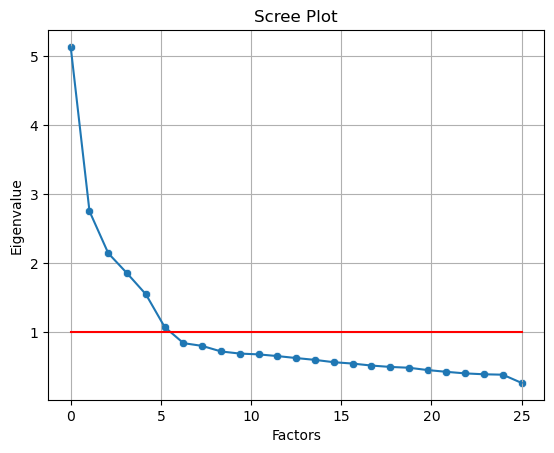

In [107]:
# scree plot
sns.scatterplot(x=np.linspace(0,len(bfi.columns), len(bfi.columns)), y=eig_val)
sns.lineplot(x=np.linspace(0,len(bfi.columns), len(bfi.columns)), y=eig_val);
sns.lineplot(x=np.linspace(0,len(bfi.columns), len(bfi.columns)), y=np.ones(len(bfi.columns)), color='red');
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

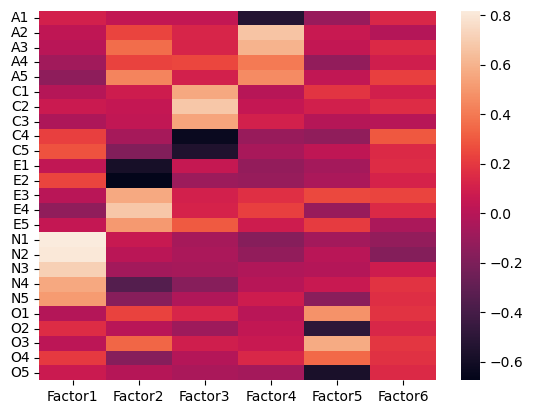

In [108]:
fa = FactorAnalyzer()
fa.set_params(n_factors=6, rotation='varimax', method='ml')
fa.fit(bfi)
fa_loading = pd.DataFrame(fa.loadings_, index=bfi.columns, columns=list(map(lambda x : f"Factor{x}".replace(".0",""), np.linspace(1,6,6))))
sns.heatmap(fa_loading);

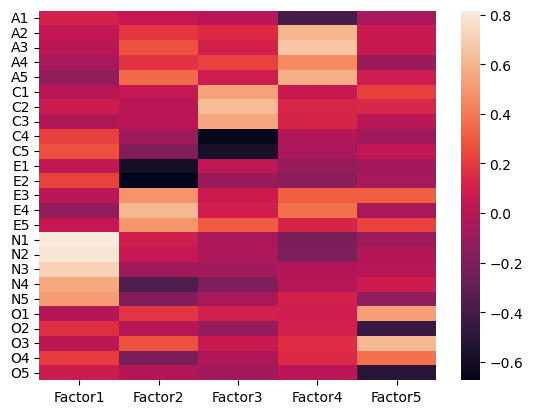

In [109]:
fa = FactorAnalyzer()
fa.set_params(n_factors=5, rotation='varimax', method='ml')
fa.fit(bfi)
fa_loading = pd.DataFrame(fa.loadings_, index=bfi.columns, columns=list(map(lambda x : f"Factor{x}".replace(".0",""), np.linspace(1,5,5))))
sns.heatmap(fa_loading);

In [110]:
pd.DataFrame(fa.get_factor_variance(), index=['loadings', 'Var', 'Cum Var'], columns=list(map(lambda x : f"Factor{x}".replace(".0",""), np.linspace(1,5,5))))

,Factor1,Factor2,Factor3,Factor4,Factor5
loadings,2.687054,2.319614,2.033578,1.978013,1.556714
Var,0.107482,0.092785,0.081343,0.079121,0.062269
Cum Var,0.107482,0.200267,0.281610,0.360730,0.422999


In [111]:
# communality
temp = pd.DataFrame(fa.loadings_**2, index=bfi.columns, columns=list(map(lambda x : f"Factor{x}".replace(".0",""), np.linspace(1,5,5))))
temp['communality'] = 1 - temp.sum(axis=1)
temp.head()

,Factor1,Factor2,Factor3,Factor4,Factor5,communality
A1,0.010727,0.002038,0.000023,0.154370,0.003209,0.829634
A2,0.001342,0.036459,0.020805,0.361571,0.003575,0.576248
A3,0.000522,0.078403,0.012000,0.438653,0.004188,0.466234
A4,0.003396,0.032916,0.054598,0.206024,0.011962,0.691104
A5,0.015298,0.123212,0.006019,0.336729,0.006845,0.511897


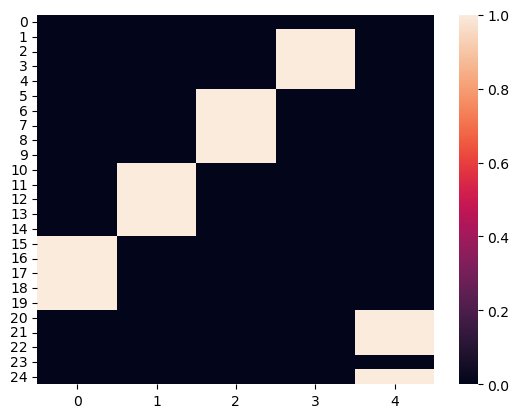

In [122]:
# 타당도 평가
fa_valid = abs(fa_loading)
sns.heatmap(fa_valid.values > 0.4);

## 9.3 다차원척도법
- 케이스 간의 거리를 바탕으로 관계구조를 시각표현하는 기법
    - 입력 : 케이스 간의 유사도를 측정한 거리데이터
    - 출력 : 케이스 들이 기하학적 공간상에 배치된 그래프
- 데이터로부터 주요 속성(차원)을 추출하고 이를 기준으로 시각화, 캐이스간의 거리는 유사도를 나타냄

In [2]:
euro = pd.read_csv("../data/kwak/eurodist.csv", index_col=0)
euro.head()

,Athens,Barcelona,Brussels,Calais,Cherbourg,Cologne,Copenhagen,Geneva,Gibraltar,Hamburg,...,Lisbon,Lyons,Madrid,Marseilles,Milan,Munich,Paris,Rome,Stockholm,Vienna
city,,,,,,,,,,,,,,,,,,,,,
Athens,0,3313,2963,3175,3339,2762,3276,2610,4485,2977,...,4532,2753,3949,2865,2282,2179,3000,817,3927,1991
Barcelona,3313,0,1318,1326,1294,1498,2218,803,1172,2018,...,1305,645,636,521,1014,1365,1033,1460,2868,1802
Brussels,2963,1318,0,204,583,206,966,677,2256,597,...,2084,690,1558,1011,925,747,285,1511,1616,1175
Calais,3175,1326,204,0,460,409,1136,747,2224,714,...,2052,739,1550,1059,1077,977,280,1662,1786,1381
Cherbourg,3339,1294,583,460,0,785,1545,853,2047,1115,...,1827,789,1347,1101,1209,1160,340,1794,2196,1588


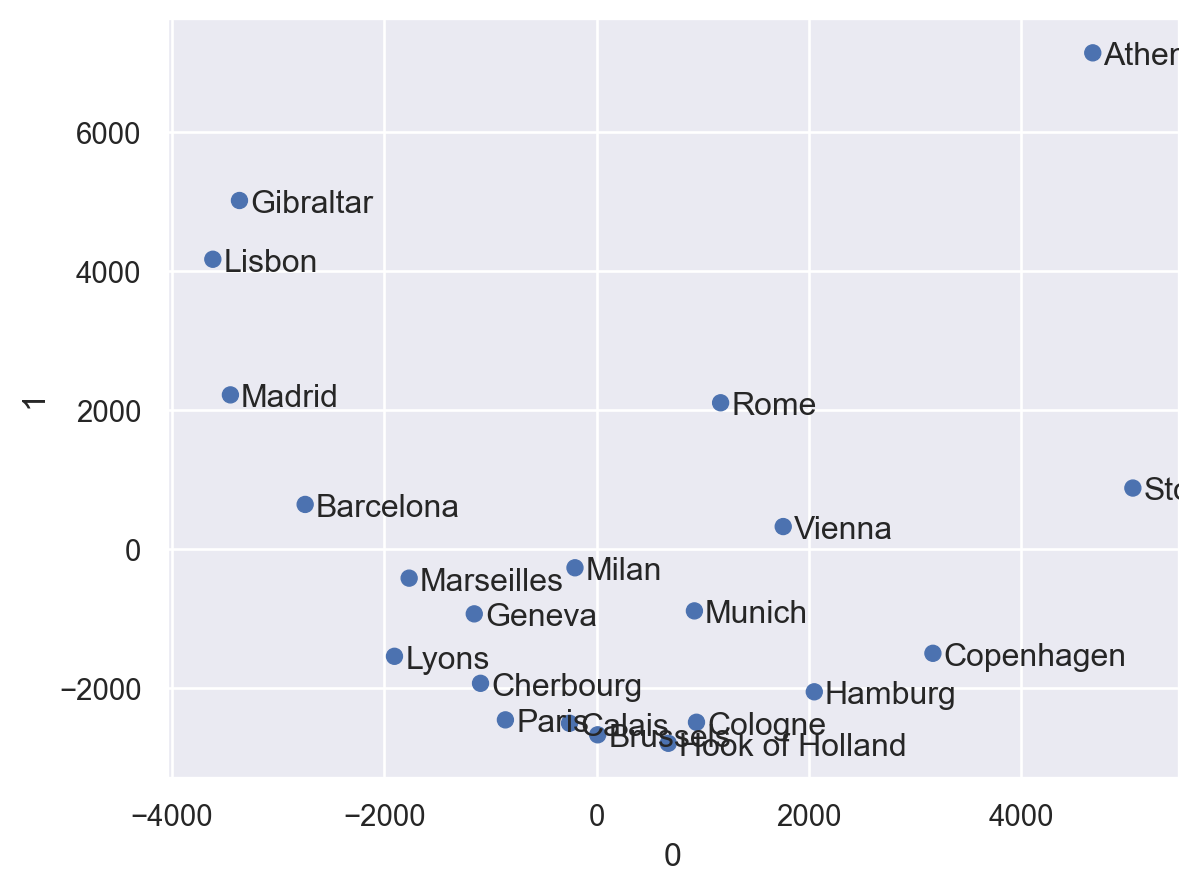

In [5]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=1)
X_mds = pd.DataFrame(mds.fit_transform(euro), index=euro.columns)
so.Plot(X_mds, x=0, y=1, text=X_mds.index).add(so.Dot()).add(so.Text(halign='left'))

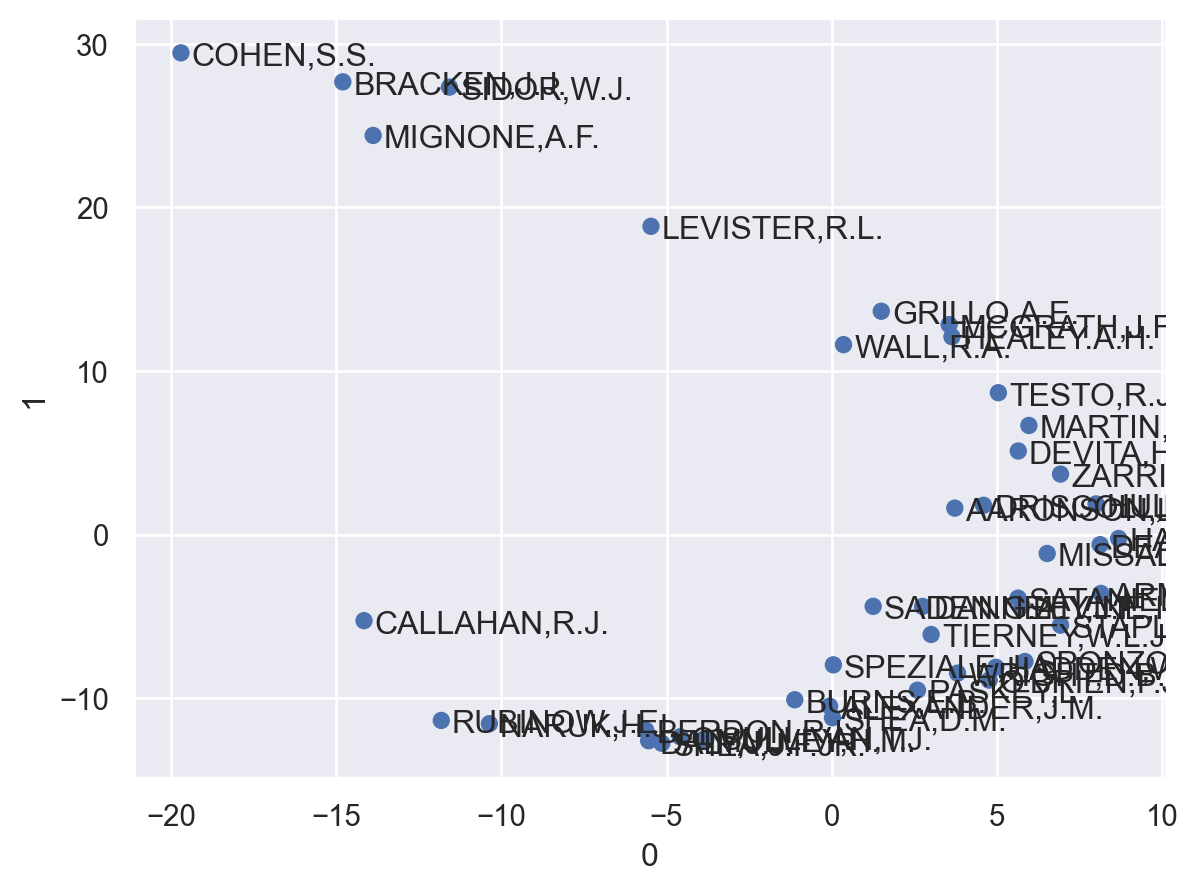

In [40]:
from scipy.spatial.distance import pdist, squareform
judge = pd.read_csv("../data/kwak/UsJudgeRatings.csv", index_col=0)

# 거리행렬 제작
temp = pd.DataFrame(squareform(pdist(judge, metric='euclidean')))

mds = MDS(n_components=2, random_state=1)
X_mds = pd.DataFrame(mds.fit_transform(temp), index=judge_dist.index)
so.Plot(X_mds, x=0, y=1, text=X_mds.index).add(so.Dot()).add(so.Text(halign='left'))

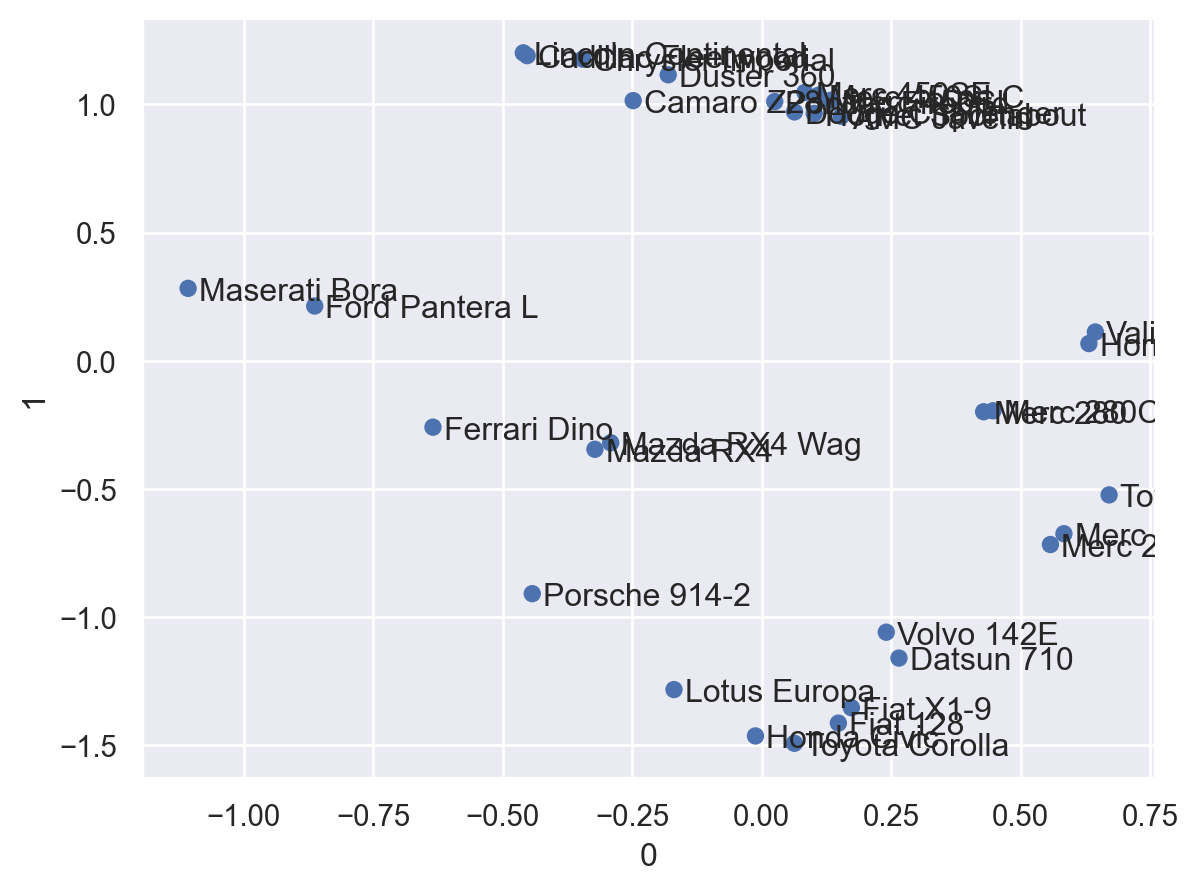

In [48]:
cars = pd.read_csv("../data/kwak/mtcars.csv", index_col=0)

# 수치형, 범주형 변주 혼합 시 gower's distance
def gower_distance(df):

    # Normalize numerical columns
    numerical_cols = df.select_dtypes(include=['float64', 'int']).columns
    df[numerical_cols] = (df[numerical_cols] - df[numerical_cols].min()) / (df[numerical_cols].max() - df[numerical_cols].min())
    
    # Initialize distance matrix
    n = df.shape[0]
    distance_matrix = np.zeros((n, n))
    
    # Calculate Gower's distance
    for i in range(n):
        for j in range(n):
            if i == j:
                distance_matrix[i, j] = 0.0
            else:
                distance = 0.0
                for col in df.columns:
                    if col in numerical_cols:
                        distance += abs(df.iloc[i][col] - df.iloc[j][col])
                    else:  # Categorical variables
                        distance += df.iloc[i][col] != df.iloc[j][col]
                
                # Normalize distance by the number of features
                distance_matrix[i, j] = distance / len(df.columns)
    
    # Convert to DataFrame for better readability
    return pd.DataFrame(distance_matrix, index=df.index, columns=df.index)

cars_dist = gower_distance(cars)

mds = MDS(n_components=2, random_state=1)
X_mds = pd.DataFrame(mds.fit_transform(cars_dist), index=cars_dist.index)
so.Plot(X_mds, x=0, y=1, text=X_mds.index).add(so.Dot()).add(so.Text(halign='left'))